In [38]:
import os
from bids import BIDSLayout
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd

# ----------------------
# 1. 使用pybids解析BIDS结构
# ----------------------
bids_root = "./ds002868"  # 替换为你的BIDS路径
layout = BIDSLayout(bids_root, derivatives=False)

# 获取所有T2w的NIfTI文件路径
files = layout.get(suffix="T2w", extension="nii.gz", return_type="filename")

# 构建数据字典列表（兼容MONAI）
data = [{"image": f} for f in files]

# ----------------------
# 2. 定义MONAI Dataset
# ----------------------
transforms = Compose([
    LoadImaged(keys="image"),
    EnsureChannelFirstd(keys="image"),
])

dataset = Dataset(data=data, transform=transforms)



In [60]:
import os
from bids import BIDSLayout
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd

# ----------------------
# 1. 使用pybids解析BIDS结构
# ----------------------
bids_root = "./ds002868"  # 替换为你的BIDS路径
layout = BIDSLayout(bids_root, derivatives=False)

# 获取所有T2w的NIfTI文件路径 
files = layout.get(suffix="T2w", extension="nii.gz", return_type="filename")

# 构建数据字典列表（兼容MONAI）
data = [{"image": f} for f in files]

# ----------------------
# 2. 定义MONAI Dataset
# ----------------------
transforms = Compose([
    LoadImaged(keys="image", image_only=False, reader="NibabelReader"),
    EnsureChannelFirstd(keys="image"),
])

dataset = Dataset(data=data, transform=transforms)

# ----------------------
# 3. 查看数据
# ----------------------
dataloader = DataLoader(dataset, batch_size=1)
for batch in dataloader:
    print("影像路径:", batch["image_meta_dict"]["filename_or_obj"])
    print("影像形状:", batch["image"].shape)
    break  # 仅查看第一个样本

print(dataloader.__len__())

影像路径: ['d:\\postgraduate\\diffusion_PA\\code\\MySynthesisCode\\dataset\\ds002868\\sub-001\\ses-1\\anat\\sub-001_ses-1_acq-RARE_T2w.nii.gz']
影像形状: torch.Size([1, 1, 120, 120, 48])
32


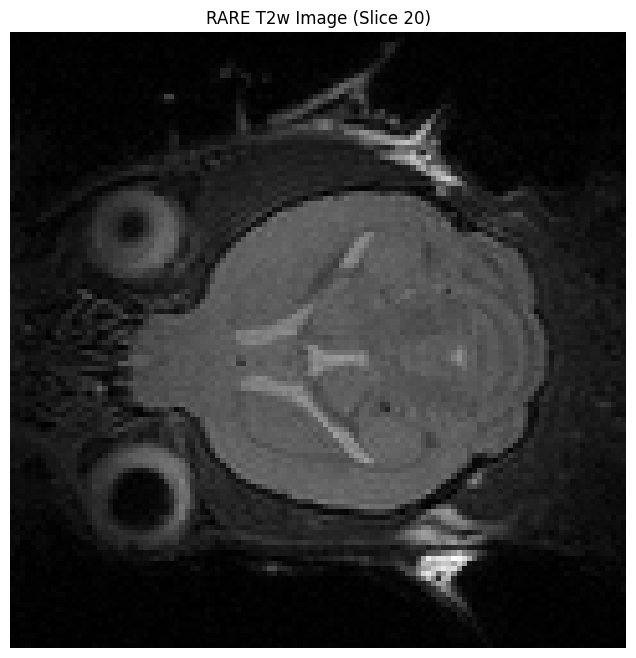

In [62]:
import matplotlib.pyplot as plt
import torch

# 获取第一个样本数据（shape: [1, 1, 120, 120, 48]）
batch = next(iter(dataloader))
image = batch["image"][0, 0].numpy()  # 提取数据：[H, W, D]

# 显示中间层切片（以深度维度第24层为例）
slice_idx = 20  # 可调整为0~47查看不同层面
plt.figure(figsize=(8, 8))
plt.imshow(image[:, :, slice_idx], cmap="gray")  #  axial平面（横断面）
plt.title(f"RARE T2w Image (Slice {slice_idx})")
plt.axis("off")
plt.show()

# print(batch)

In [ ]:
for slice_idx in [10, 15, 20]:  # 查看不同层面
    plt.imshow(image[:, :, slice_idx], cmap="gray")
    plt.title(f"Slice {slice_idx}")
    plt.show()

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from monai.data import BIDSDataset, DataLoader, partition_dataset, CacheDataset
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    N4BiasFieldCorrectiond,
    ScaleIntensityd,
    ToTensord,
    SaveImaged
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
import torch
from torch.optim import Adam

# 设置随机种子（确保可复现性）
set_determinism(42)

# ----------------------------------------
# 1. 数据路径与参数配置
# ----------------------------------------
bids_root = "data/ds002868"  # BIDS数据集根目录
output_dir = "./processed_data"  # 预处理输出目录
os.makedirs(output_dir, exist_ok=True)

# 扫描参数筛选（可选）
filters = {
    "suffix": "T2w",  # 只加载T2加权像
    "extension": "nii.gz",  # 压缩的NIfTI文件
    "acquisition": "RARE"  # 仅选择RARE序列
}

# ----------------------------------------
# 2. 数据加载与预处理流程
# ----------------------------------------
# 定义预处理变换
transforms = Compose([
    # 加载影像和元数据
    LoadImaged(keys="image", reader="NibabelReader", ensure_channel_first=False),
    # 添加通道维度（MONAI默认通道优先）
    EnsureChannelFirstd(keys="image"),
    # 偏置场校正（针对RARE序列的B0不均匀性）
    N4BiasFieldCorrectiond(
        keys="image",
        num_control_points=9,
        bias_field_smoothing=0.1,
        shrink_factor=2
    ),
    # 重采样到各向同性体素（1mm³）
    Spacingd(keys="image", pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    # 强度归一化（0-1范围）
    ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
    # 转换为PyTorch张量
    ToTensord(keys="image"),
    # 保存预处理结果（可选）
    SaveImaged(
        keys="image",
        meta_keys="image_meta_dict",
        output_dir=output_dir,
        output_postfix="preprocessed",
        resample=False
    )
])

# 加载BIDS数据集
dataset = BIDSDataset(
    data_dir=bids_root,
    transform=transforms,
    **filters
)

# 划分训练集和验证集（80%训练，20%验证）
train_data, val_data = partition_dataset(
    data=dataset.data,
    ratios=[0.8, 0.2],
    shuffle=True,
    seed=42
)

# 使用缓存加速（适用于大型数据集）
train_dataset = CacheDataset(
    data=train_data,
    transform=transforms,
    cache_rate=1.0,
    num_workers=4
)
val_dataset = CacheDataset(
    data=val_data,
    transform=transforms,
    cache_rate=1.0,
    num_workers=4
)

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2
)


# ----------------------------------------
# 3. 可视化预处理结果（可选）
# ----------------------------------------
def plot_slice(batch, slice_idx=30):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(batch["image"][0, 0, :, :, slice_idx], cmap="gray")
    plt.title("Preprocessed Image")
    plt.axis("off")

    # 显示元数据中的关键参数
    metadata = batch["image_meta_dict"]
    tr = metadata["RepetitionTime"][0] if isinstance(metadata["RepetitionTime"], list) else metadata["RepetitionTime"]
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, f"TR: {tr} s\nSequence: {metadata.get('PulseSequenceType', 'N/A')}", fontsize=12)
    plt.axis("off")
    plt.show()


# 查看第一个批次的数据
first_batch = next(iter(train_loader))
plot_slice(first_batch)

# ----------------------------------------
# 4. 构建与训练深度学习模型（示例：3D UNet分割）
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型（输入通道1，输出通道1，适用于二分类）
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

# 定义损失函数和优化器
loss_function = DiceLoss(sigmoid=True)
optimizer = Adam(model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=True, reduction="mean")

# 训练循环
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch in progress:
        inputs = batch["image"].to(device)
        # 假设有标签数据（实际需替换为您的标签加载逻辑）
        labels = torch.randint(0, 2, inputs.shape).float().to(device)  # 模拟二分类标签

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # 验证阶段
    model.eval()
    val_dice = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch["image"].to(device)
            val_labels = torch.randint(0, 2, val_inputs.shape).float().to(device)
            val_outputs = model(val_inputs)
            dice_metric(y_pred=val_outputs, y=val_labels)
            val_dice = dice_metric.aggregate().item()
            dice_metric.reset()

    print(f"Epoch {epoch + 1}, Avg Loss: {epoch_loss / len(train_loader):.4f}, Val Dice: {val_dice:.4f}")

# ----------------------------------------
# 5. 元数据导出与分析（可选）
# ----------------------------------------
# 将所有元数据保存为CSV
metadata_list = []
for item in dataset.data:
    with open(item["image"].replace(".nii.gz", ".json")) as f:
        meta = json.load(f)
        meta["subject"] = item["image"].split("/")[-3]  # 提取被试ID
        metadata_list.append(meta)

pd.DataFrame(metadata_list).to_csv(os.path.join(output_dir, "metadata_summary.csv"), index=False)
